# Classification Data Preparation
**Hunter Estuary KBA, NSW - Change Detection**


Author: Michael Dear, June 2024

This notebook adds classification variables to the dataset.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [2]:
from global_params import *

# Random state for reproducibility
random_state = 11

y_var = ['class_num']

## Step 1: Load data

In [3]:
ds = xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [4]:
# Replace NaN with -999
ds = ds.where(ds.notnull(), -999)

In [5]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [6]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [7]:
# Select the polygon to use
poly = poly[poly['name']=='Buffered 1000m']
poly

,name,description,timestamp,begin,end,altitudemode,tessellate,extrude,visibility,draworder,icon,snippet,geometry
2,Buffered 1000m,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,MULTIPOLYGON Z (((1814655.723 -3723941.457 0.0...


In [8]:
# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [9]:
# Put the period names in a list for convenience.
periods = list(ds.period.values)
periods

['Sep 2003', 'Sep 2023']

## Step 2: Ground-truth Points (GTP)
The process is:
1. Create polygons for each class using QGIS, Google Earth, and composite plots for each period.
2. Intersect the polygons with the data array to create a candidate set of points for each period.
3. Reduce the candidate set in each class to the size of the smallest class.
4. Train the classifier.
5. Predict.

See https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe for converting a data array to points.

In [11]:
# Read in the labelled polygons
gtp_polys = [gpd.read_file(vector_dir+'gtp_polygons_'+str(i)+'.geojson').to_crs(crs) for i in [0,1]]

-----
#### (Optional) Apply internal buffer

In [12]:
# Apply internal buffer if required
for i in [0,1]:
    gtp_polys[i]['geometry'] = gtp_polys[i].buffer(-10)

------

#### Check the data

In [13]:
for i in [0,1]:
    print(gtp_polys[i].head(6))

   class_num   class_name                                           geometry
0          2    Developed  MULTIPOLYGON (((1829986.860 -3730239.381, 1830...
1          6       Wooded  MULTIPOLYGON (((1833464.467 -3722456.522, 1833...
2          1        Water  MULTIPOLYGON (((1831249.516 -3722539.018, 1831...
3          3  Green Grass  MULTIPOLYGON (((1832542.021 -3720796.370, 1833...
4          5        Swamp  MULTIPOLYGON (((1829002.467 -3721334.843, 1829...
5          4  Brown Grass  MULTIPOLYGON (((1827723.345 -3726985.121, 1828...
   class_num   class_name                                           geometry
0          2    Developed  MULTIPOLYGON (((1829986.860 -3730239.381, 1830...
1          6       Wooded  MULTIPOLYGON (((1833464.467 -3722456.522, 1833...
2          1        Water  MULTIPOLYGON (((1831249.516 -3722539.018, 1831...
3          4  Brown Grass  MULTIPOLYGON (((1826384.549 -3722484.840, 1826...
4          5        Swamp  MULTIPOLYGON (((1819311.043 -3722117.519, 1821...

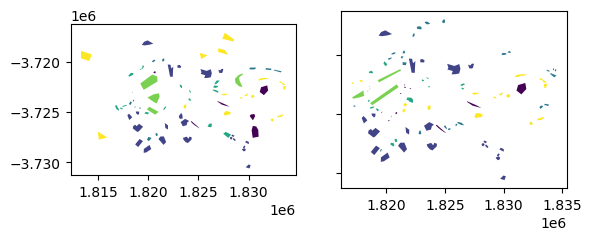

In [39]:
# Plot to check the data
fig, axes = plt.subplots(1,2, sharey=True)
for i in [0,1]:
    unq_nums = np.unique(gtp_polys[i]['class_num'])
    gtp_polys[i].plot(ax=axes[i], column='class_num')

#### Select the variables to use

In [12]:
X_vars = list(ds.data_vars.keys())[:9]
X_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI']

#### Create the base GTP data frames

In [13]:
gtp_base = [[],[]]
thold_var = ''

for i in [0,1]:
    # Convert the data array to a data frame
    df = ds.isel(period=i).to_dataframe().reset_index()
    
    # Convert to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y)).set_crs(crs)

    # Make a bare/water class using NDVI threshold
    if thold_var!='':
        bare = gdf[gdf[thold_var]<= -0.025]
        bare['class_num'] = 0
        bare['class_name'] = 'Water'
    
    # Intersect the points with the polygons
    gdf = gpd.sjoin(gdf, gtp_polys[i], how='inner') # Limit to polygon

    if thold_var!='':
        gtp_base[i] = pd.concat([gdf[X_vars+['class_num','class_name','geometry']], bare[X_vars+['class_num','class_name','geometry']]], axis=0)
    else:
        gtp_base[i] = gdf[X_vars+['class_num','class_name','geometry']]

    gtp_base[i]['class_num'] = gtp_base[i]['class_num'].astype(np.int16)

#### Check the data

In [17]:
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i].head())
    print('--------------')

Period: 0
       nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
12191      423.5       249.0        435.0     2022.0        1144.5   
12969      463.5       292.5        468.5     1829.5        1282.5   
12970      398.5       254.0        429.5     1916.5        1144.0   
12971      420.5       266.0        432.5     2053.0        1139.0   
13748      480.0       304.5        509.5     1906.5        1292.0   

       nbart_swir_2      NDVI       NBR      NDWI  class_num class_name  \
12191         562.0  0.655952  0.564469 -0.648909          6     Wooded   
12969         691.5  0.597180  0.450674 -0.595462          6     Wooded   
12970         515.0  0.657097  0.576247 -0.637180          6     Wooded   
12971         519.0  0.662220  0.596566 -0.654917          6     Wooded   
13748         627.0  0.600103  0.504367 -0.581278          6     Wooded   

                               geometry  
12191  POINT (1827645.000 -3717135.000)  
12969  POINT (1827615.000 -3717165

#### Count the number of points in each class

In [14]:
# Count the number of points in each class
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i]['class_num'].value_counts())
    print('--------------')


Period: 0
class_num
2    5212
5    4729
6    2236
1    1780
4    1271
3     684
Name: count, dtype: int64
--------------
Period: 1
class_num
2    5046
5    1597
6    1204
3    1112
1     881
4     661
Name: count, dtype: int64
--------------


#### (Optional) Combine classes

In [104]:
for i in [0,1]:
    print(periods[i])
    print('============')
    print(gtp_base[i]['class_num'].unique())
    print(gtp_base[i]['class_name'].unique())
    print('--------------')

Dec 2014
[0 1 6 2 4 3 5]
['Bare' 'Developed' 'Brown Crops' 'Grass' 'Dense Wooded' 'Medium Wooded'
 'Green Crops']
--------------
Dec 2023
[0 1 6 2 4 3 5]
['Bare' 'Developed' 'Brown Crops' 'Grass' 'Dense Wooded' 'Medium Wooded'
 'Green Crops']
--------------


In [125]:
for i in [0,1]:
    gtp_base[i]['class_num'][gtp_base[i]['class_num']==0] = 1
    gtp_base[i]['class_name'][gtp_base[i]['class_name']=='Water'] = 'Bare'
    gtp_base[i]['class_num'] = gtp_base[i]['class_num'] - 1

#### Reduce each class to the size of the smallest class

In [67]:
# Reduce each class to the size of the smallest class
sample_size = np.min([gtp_base[i]['class_num'].value_counts().min() for i in [0,1]])

gtp_equal = [pd.concat([gtp_base[i][gtp_base[i]['class_num']==cl].sample(sample_size, random_state=random_state) 
                for cl in gtp_base[i]['class_num'].unique()], axis=0) 
                for i in [0,1]]

In [16]:
# Count the number of points in each class
for i in [0,1]:
    print(periods[i])
    print('============')
    print(gtp_equal[i]['class_num'].value_counts())
    print('--------------')


Sep 2003
class_num
6    661
2    661
3    661
4    661
1    661
5    661
Name: count, dtype: int64
--------------
Sep 2023
class_num
3    661
2    661
4    661
5    661
6    661
1    661
Name: count, dtype: int64
--------------


#### Check for nodata_val
If the nodata_val occurs in the training data, go back and modify the GTP polygons to remove missing data.

In [19]:
# Count the number of missing values
for i in [0,1]:
    print(periods[i])
    print('============')
    # print(gtp_equal[i].isnull().sum())
    print((gtp_equal[i]==nodata_val).sum())
    print('--------------')


Sep 2003
nbart_red       0
nbart_blue      0
nbart_green     0
nbart_nir       0
nbart_swir_1    0
nbart_swir_2    0
NDVI            0
NBR             0
NDWI            0
class_num       0
class_name      0
geometry        0
dtype: int64
--------------
Sep 2023
nbart_red       0
nbart_blue      0
nbart_green     0
nbart_nir       0
nbart_swir_1    0
nbart_swir_2    0
NDVI            0
NBR             0
NDWI            0
class_num       0
class_name      0
geometry        0
dtype: int64
--------------


#### Add a nodata class

In [68]:
# Get the size of the classes
cl_size = len(gtp_equal[0][gtp_equal[0]['class_num']==1])
print('Class size:', cl_size)

# Create an array of -999
nodata_df = pd.DataFrame([[-999 for i in gtp_equal[0].columns] for j in np.arange(cl_size)], columns=gtp_equal[0].columns)
nodata_df['class_num'][nodata_df['class_num']==-999] = 0
nodata_df['class_name'][nodata_df['class_name']==-999] = 'No Data'
# print(nodata_df.shape)
# print(nodata_df.head())

# Append to each df in gtp_equal
gtp_equal = [pd.concat([df, nodata_df]) for df in gtp_equal]


Class size: 661


In [69]:
# Count the number of points in each class
for i in [0,1]:
    print(periods[i])
    print('============')
    print(gtp_equal[i][['class_num', 'class_name']].value_counts())
    print('--------------')


Sep 2003
class_num  class_name 
0          No Data        661
1          Water          661
2          Developed      661
3          Green Grass    661
4          Brown Grass    661
5          Swamp          661
6          Wooded         661
Name: count, dtype: int64
--------------
Sep 2023
class_num  class_name 
0          No Data        661
1          Water          661
2          Developed      661
3          Green Grass    661
4          Brown Grass    661
5          Swamp          661
6          Wooded         661
Name: count, dtype: int64
--------------


####  Create the class names list

In [70]:
# Create the cl_names list
# See https://stackoverflow.com/a/52270276/8299958 for joining pandas columns
cl_num_name = np.char.split(
    (np.unique(gtp_equal[0][['class_num','class_name']]
     .apply(lambda row: ', '.join(row.values.astype(str)), axis=1))
    ).astype(str),
    sep=', '
)
cl_names = [cl_num_name[i][1] for i in np.arange(len(cl_num_name))]
cl_names

['No Data',
 'Water',
 'Developed',
 'Green Grass',
 'Brown Grass',
 'Swamp',
 'Wooded']

## Step 3: Random Forest
Based on
* https://www.datacamp.com/tutorial/random-forests-classifier-python
* https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial

#### Imports

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#### Create the training and test sets

In [72]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI',
 'Kmeans_Class',
 'RF_Class']

In [73]:
rf_vars = [list(ds.data_vars.keys())[i] for i in np.arange(9)]
rf_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI']

In [74]:
X = [gdf[rf_vars] for gdf in gtp_equal]
y = [gdf[y_var] for gdf in gtp_equal]

In [75]:
# Need to use `stratify` to get the same number of samples in each class
# https://stackoverflow.com/a/29477256/8299958
gtp_tt = [train_test_split(X[i], y[i], test_size=0.2, stratify=y[i], random_state=random_state) for i in [0,1]]

In [76]:

pd.DataFrame([[int(len(gtp_tt[i][0])/len(cl_names)),int(len(gtp_tt[i][1])/len(cl_names))] for i in [0,1]],
            columns=['Train', 'Test'],
            index=periods)

,Train,Test
Sep 2003,528,132
Sep 2023,528,132


#### Check the data

In [29]:
for i in [0,1]:
    print(gtp_tt[i][0][:5])
    print(gtp_tt[i][2][:5])

        nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
226508      438.5       356.0        497.5      274.5         115.5   
215274      558.0       294.0        472.5     1202.5        1480.5   
284627      984.0       663.0        922.5     2502.0        2180.5   
257298     1029.5       662.0       1052.0     2535.0        2179.0   
280270      403.5       333.5        522.0      271.0         128.5   

        nbart_swir_2      NDVI       NBR      NDWI  
226508         131.5 -0.253335  0.307808  0.319090  
215274         700.5  0.383419  0.264933 -0.455011  
284627        1494.5  0.437696  0.251244 -0.466501  
257298        1453.0  0.422335  0.271331 -0.413486  
280270          89.5 -0.182358  0.504091  0.312615  
        class_num
226508          1
215274          5
284627          2
257298          2
280270          1
        nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
157209      480.0       463.0        573.0      216.0          68.5   
13812

#### Basic RF

In [77]:
%%time

# List to hold the trained classifiers
rfs = []
# List to hold the accuracies
acc = []
# List to hold the precision and recall data frames
pre_rec = []
# List to hold the confusion matrix data frames
cm = []
# List to hold the feature scores
feat_scores = []


for i in [0,1]:
    # Create and fit the RF classifier
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(gtp_tt[i][0], gtp_tt[i][2])

    # Append model to list
    rfs.append(rf)
    
    # Predict
    y_pred = rf.predict(gtp_tt[i][1])

    # Assess accuracy, precision, recall
    acc.append(accuracy_score(gtp_tt[i][3], y_pred))
    pre_rec.append(pd.DataFrame({'Precision': precision_score(gtp_tt[i][3], y_pred, average=None),
                               'Recall': recall_score(gtp_tt[i][3], y_pred, average=None)
                              },
                               index=cl_names)
                  )
    
    print(periods[i])
    print('============')
    print('Accuracy =', acc[i])
    print()
    print('Precision and Recall')
    print(pre_rec[i])
    print()
    
    # List the importance of features
    print('Feature Importance')
    feat_scores.append(pd.DataFrame({'Importance':rf.feature_importances_}, index=gtp_tt[i][0].columns))
    print(feat_scores[i])
    print()

    # Confusion matrix
    cm.append(pd.DataFrame(confusion_matrix(gtp_tt[i][3], y_pred),
                           columns = cl_names,
                                  index=cl_names
                          )
             )
    print('Confusion matrix')
    print(cm[i])
    print()

Sep 2003
Accuracy = 0.978401727861771

Precision and Recall
             Precision    Recall
No Data       1.000000  1.000000
Water         1.000000  1.000000
Developed     0.977099  0.969697
Green Grass   0.985075  1.000000
Brown Grass   0.968992  0.946970
Swamp         0.946970  0.946970
Wooded        0.970149  0.984848

Feature Importance
              Importance
nbart_red       0.070916
nbart_blue      0.107936
nbart_green     0.133722
nbart_nir       0.111615
nbart_swir_1    0.150310
nbart_swir_2    0.104648
NDVI            0.109310
NBR             0.062544
NDWI            0.149000

Confusion matrix
             No Data  Water  Developed  Green Grass  Brown Grass  Swamp  \
No Data          133      0          0            0            0      0   
Water              0    133          0            0            0      0   
Developed          0      0        128            0            1      3   
Green Grass        0      0          0          132            0      0   
Brown Grass  

In [78]:
# For copying to the report
cm[0]
# cm[1]

,No Data,Water,Developed,Green Grass,Brown Grass,Swamp,Wooded
No Data,133,0,0,0,0,0,0
Water,0,133,0,0,0,0,0
Developed,0,0,128,0,1,3,0
Green Grass,0,0,0,132,0,0,0
Brown Grass,0,0,3,2,125,2,0
Swamp,0,0,0,0,3,125,4
Wooded,0,0,0,0,0,2,130


#### RF With Hyperparameter Tuning
*Warning*: This will take a long time to complete.

In [488]:
%%time

# List to hold the trained classifiers
rfs = []

for i in [0,1]:
    # Create the parameter grid
    param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

    # Create a random forest classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf, 
                                     param_distributions = param_dist, 
                                     n_iter=5, 
                                     cv=5)

    # Split the data into training and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
   
    # Fit the random_search to the data
    rand_search.fit(gtp_tt[i][0], gtp_tt[i][2])

    # Store the best model
    best_rf = rand_search.best_estimator_

    # Predict
    y_pred = best_rf.predict(gtp_tt[i][1])
    accuracy = accuracy_score(gtp_tt[i][3], y_pred)

    # Append best model to list
    rfs.append(best_rf)

    print(periods[i])
    print('============')
    # print('y_test:', y_test['class'].values)
    # print('y_pred:', y_pred)
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(best_rf.feature_importances_, index=gtp_tt[i][0].columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(gtp_tt[i][3], y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Jul 2015
Accuracy: 0.938006723353767

Feature Importance
nbart_swir_2    0.245012
nbart_red       0.238164
nbart_swir_1    0.156639
nbart_green     0.133209
NDVI            0.118846
nbart_blue      0.075049
nbart_nir       0.033079
dtype: float64

Confusion matrix
[[  88    4   79    3]
 [   0  304  244    2]
 [  10   84 2573  133]
 [   0    0   68 6522]]



KeyboardInterrupt: 

#### Predictions for each period

In [79]:
rf_arrs = [[] for i in [0,1]]

In [80]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

In [81]:
%%time
rf_arrs = [rfs[i].predict(ds.sel(period=periods[i]).to_dataframe()[rf_vars].values).reshape(w,l) for i, period in enumerate(periods)]

CPU times: total: 5.77 s
Wall time: 6.7 s


#### Add the classification data to the dataset

In [82]:
ds = ds.assign({'RF_Class': (('period','y','x'), rf_arrs)})

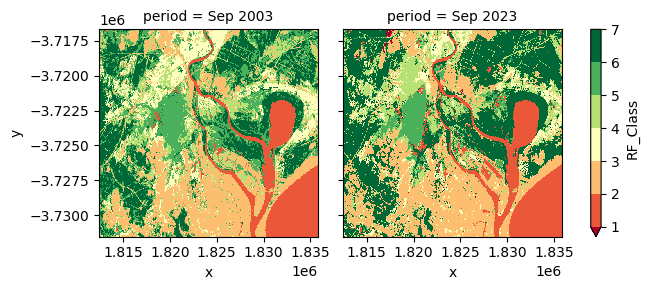

In [84]:
ds.RF_Class.plot(col='period', 
                 levels=np.unique(ds.RF_Class)+1,
                 cmap='RdYlGn')

## Step 4: Export data 

### netCDF

In [85]:
# Save as netCDF
ds.to_netcdf(netcdf_dir+study_area_abbrev+'.nc')

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [86]:
for period in ds.period.values:
     (ds
     .sel(period=period)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'.tiff')
     )

In [73]:
# Single variable
class_var = 'RF_Class'
for period in ds.period.values:
     (ds[class_var]
     .sel(period=period)
     # .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'_'+class_var+'.tiff')
     )

---------

In [74]:
ds

<xarray.Dataset>
Dimensions:       (period: 2, y: 496, x: 779)
Coordinates:
  * y             (y) float64 -3.717e+06 -3.717e+06 ... -3.732e+06 -3.732e+06
  * x             (x) float64 1.812e+06 1.812e+06 ... 1.836e+06 1.836e+06
    spatial_ref   int32 3577
  * period        (period) <U8 'Sep 2003' 'Sep 2023'
Data variables:
    nbart_red     (period, y, x) float32 752.5 693.5 692.5 ... 176.0 176.5 175.0
    nbart_blue    (period, y, x) float32 397.5 355.5 367.0 ... 387.5 388.5 389.0
    nbart_green   (period, y, x) float32 659.5 624.5 630.5 ... 305.5 304.0 303.0
    nbart_nir     (period, y, x) float32 2.076e+03 2.06e+03 ... 124.5 125.5
    nbart_swir_1  (period, y, x) float32 2.264e+03 1.94e+03 ... 53.0 53.5
    nbart_swir_2  (period, y, x) float32 1.315e+03 1.072e+03 ... 39.5 41.5
    NDVI          (period, y, x) float32 0.4719 0.5012 ... -0.1865 -0.1794
    NBR           (period, y, x) float32 0.2247 0.3167 0.3166 ... 0.5354 0.5104
    NDWI          (period, y, x) float32 -0.5204 -0.5371 ... 0.4309 0.4268
    Kmeans_Class  (period, y, x) int16 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    RF_Class      (period, y, x) int16 4 4 4 4 4 4 4 4 4 4 ... 1 1 1 1 1 1 1 1 1